In [200]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pickle


In [201]:
! pip install tensorflow==2.12

In [202]:
import torch.nn as nn
from keras.preprocessing.text import Tokenizer
import torchtext
from keras.utils import pad_sequences
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef


In [203]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/berkkucukk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/berkkucukk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [204]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [205]:
dataset = pd.read_csv("data.csv")
dataset = dataset.dropna()
#dataset['Label'] = dataset['Label'].replace(-1, 2)

In [206]:
dataset['Resume'] = dataset['Resume'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

In [207]:
dataset['Resume'] = [remove_stopwords(text) if isinstance(text, str) else '' for text in dataset['Resume']]

In [208]:
dataset['Resume'][0]

'Database Administrator Database Administrator Database Administrator Family Private Care LLC Lawrenceville GA selfmotivated Production SQL Server Database Administrator possesses strong analytical problem solving skills experience includes SQL Server 2005 2008 2012 2014 SSIS well clustering mirroring high availability solutions OLTP environments proficient database backup recovery performance tuning maintenance tasks security consolidation confident would make beneficial addition company course career thus far designed databases fit variety needs successfully ensured security databases problemsolved order meet backend frontend needs installed tested new versions database management systems customized installed applications meticulously monitored performance smoothest frontend experience possible 5 6 years working databases Work Experience Database Administrator Family Private Care LLC Roswell GA April 2017 Present Confirm backups made successfully saved secure location Planning backup

In [209]:
dataset = dataset[~dataset['Label'].str.contains(',')]


In [210]:
dataset["Label"].unique()

array(['Database_Administrator', 'Systems_Administrator',
       'Project_manager', 'Software_Developer', 'Network_Administrator',
       'Security_Analyst'], dtype=object)

In [211]:
dataset["Label"].value_counts()

Label
Systems_Administrator     2349
Project_manager           2339
Database_Administrator    2225
Software_Developer        1991
Security_Analyst          1563
Network_Administrator     1466
Name: count, dtype: int64

In [212]:
category_size = len(dataset["Label"].unique())
category_size

6

In [213]:

label_encoder = LabelEncoder()
dataset["encoded_category"] = label_encoder.fit_transform(dataset["Label"])


In [214]:
target = dataset["encoded_category"].values.tolist()
data = dataset["Resume"].values.tolist()

In [215]:
print("Class Lenght: ", len(target))

Class Lenght:  11933


In [216]:
print("Data Lenght: ", len(data))

Data Lenght:  11933


In [217]:
cutoff = int(len(data) * 0.80) #listeyi böldük
x_train, x_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

In [218]:
x_train[299]

'Database Administrator Database Administrator External Fraud Investigator US Bank Columbus OH Authorized work US employer Work Experience Database Administrator Ohio School Boards Association Columbus OH July 2019 Present Assisting handling database every form Ohio Public School Districts Auditing 200 policies daily formatting correct typing correct location correct code Customer Service Associate Farmers New World Life July 2018 Present First line support insurance agents Farmers Life Insurance customers Basic coding systems used daily contact customers Follow numerous customers daily regarding life insurance policies finances going towards policy Daily processing HIPAA sensitive documents customers agents 50 incoming calls regarding life insurance policies daily Daily deescalation techniques implemented call control Daily research regarding life insurance policy changes Weekly team meetings meetings supervisors going performance External Fraud Investigator Robert Half US Bank Novemb

In [219]:
y_train[299]

0

In [220]:
categories = dataset['Label'].unique()
categories

array(['Database_Administrator', 'Systems_Administrator',
       'Project_manager', 'Software_Developer', 'Network_Administrator',
       'Security_Analyst'], dtype=object)

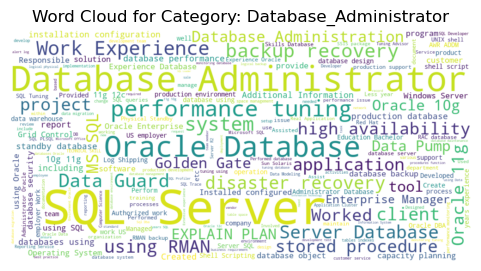

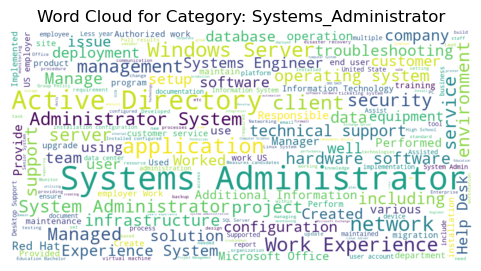

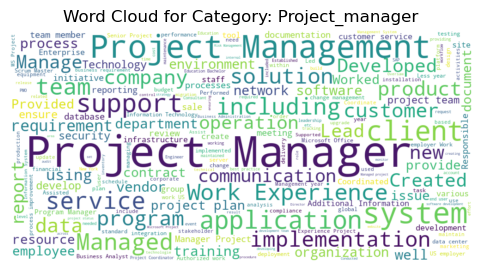

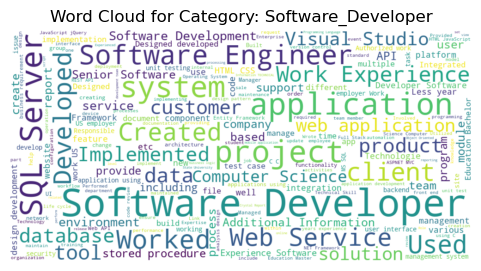

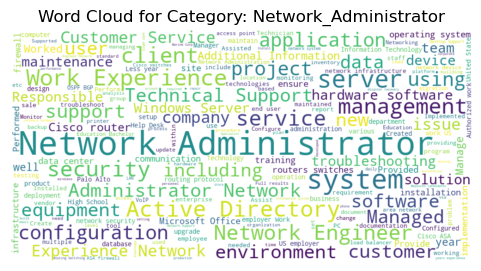

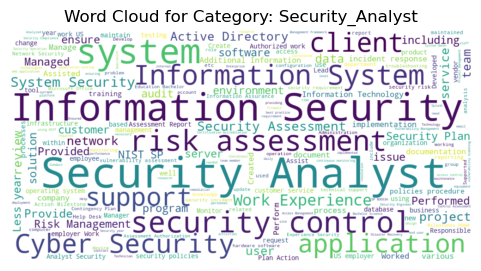

In [221]:
from wordcloud import WordCloud
# Veri çerçevesindeki kategorileri alın
categories = dataset['Label'].unique()

for category in categories:
    # Kategorilere göre filtreleme yapın
    category_data = dataset.loc[dataset['Label'] == category, 'Resume'].values
    
    # Metni birleştirme
    category_text_data = " ".join(np.vectorize(str)(category_data))
    
    # Kelime bulutu nesnesi oluşturma
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(category_text_data)

    # Grafiği gösterme
    plt.figure(figsize=(7, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Eksenleri kapatma
    plt.title(f'Word Cloud for Category: {category}')
    plt.show()


In [222]:
def top_words_per_category(df):
    result = pd.DataFrame(columns=['Category', 'Top Words'])
    
    for category in df['Label'].unique():
        category_data = df[df['Label'] == category]
        text_data = category_data['Resume'].values
        
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(text_data)
        word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        
        top_words = word_counts.sum().sort_values(ascending=False).index[:5].tolist()
        
        result = pd.concat([result, pd.DataFrame({'Category': [category], 'Top Words': [top_words]})], ignore_index=True)
    
    return result


In [223]:
result_df = top_words_per_category(dataset)
result_df

,Category,Top Words
0,Database_Administrator,"[database, sql, oracle, data, server]"
1,Systems_Administrator,"[systems, support, administrator, system, server]"
2,Project_manager,"[project, management, manager, business, team]"
3,Software_Developer,"[software, using, data, developer, application]"
4,Network_Administrator,"[network, cisco, support, administrator, exper..."
5,Security_Analyst,"[security, information, management, system, an..."


In [224]:
num_words = 1000 # kelime haznemizdeki max kelime sayısı
tokenizer = Tokenizer(num_words=num_words)

In [225]:
data = np.array(data)

In [226]:
data

array(['Database Administrator Database Administrator Database Administrator Family Private Care LLC Lawrenceville GA selfmotivated Production SQL Server Database Administrator possesses strong analytical problem solving skills experience includes SQL Server 2005 2008 2012 2014 SSIS well clustering mirroring high availability solutions OLTP environments proficient database backup recovery performance tuning maintenance tasks security consolidation confident would make beneficial addition company course career thus far designed databases fit variety needs successfully ensured security databases problemsolved order meet backend frontend needs installed tested new versions database management systems customized installed applications meticulously monitored performance smoothest frontend experience possible 5 6 years working databases Work Experience Database Administrator Family Private Care LLC Roswell GA April 2017 Present Confirm backups made successfully saved secure location Planning

In [227]:
tokenizer.fit_on_texts(data)

In [228]:
tokenizer.word_index

{'database': 1,
 'data': 2,
 'project': 3,
 'management': 4,
 'security': 5,
 'using': 6,
 'systems': 7,
 'server': 8,
 'support': 9,
 'system': 10,
 'software': 11,
 'sql': 12,
 'experience': 13,
 'network': 14,
 'years': 15,
 'work': 16,
 'oracle': 17,
 'information': 18,
 'business': 19,
 'team': 20,
 'administrator': 21,
 'development': 22,
 'skills': 23,
 'new': 24,
 'manager': 25,
 'application': 26,
 'windows': 27,
 'technical': 28,
 'issues': 29,
 'service': 30,
 'databases': 31,
 'services': 32,
 'performance': 33,
 'servers': 34,
 'microsoft': 35,
 'environment': 36,
 'applications': 37,
 'managed': 38,
 'including': 39,
 'design': 40,
 'developed': 41,
 'projects': 42,
 'worked': 43,
 'present': 44,
 'user': 45,
 'customer': 46,
 'created': 47,
 'technology': 48,
 '2016': 49,
 'web': 50,
 'computer': 51,
 'reports': 52,
 'process': 53,
 'administration': 54,
 'requirements': 55,
 'university': 56,
 'education': 57,
 'implemented': 58,
 'users': 59,
 'analysis': 60,
 'testing

In [229]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


In [230]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [231]:
x_train[10]

'Database Administrator Database Administrator Database Administrator Booz Allen Hamilton Los Angeles CA professional 8 years experience area Database Technology experience designing developing managing troubleshooting Databases managed thousands databases across Development TEST QAT PROD environments using command line Oracle GUI tools like TOAD Enterprise Manager Cloud 12c Configured Oracle Fusion Middleware SOA run Oracle EBS applications Installing Oracle Golden gate RHEL setup table level replication well DDL replication Evaluated Oracle 11gR2 Golden Gate future purposes reducing complexity involved Oracle Streams Set Active Dataguard Configurations oracle database 11203 databases sizes ranging 500GB 30TB Designed GoldenGate configuration databases implemented filters rules meet business usage reduce load production databases better performance replication multiple sites Migrated upgraded Oracle 11gR2 Databases Sun Solaris 10 Red hat Linux 5 using Goldengate Worked SQL Tuning use 

In [232]:
print(x_train_tokens[10])

[1, 21, 1, 21, 1, 21, 166, 180, 427, 15, 13, 542, 1, 48, 13, 422, 235, 155, 82, 31, 38, 31, 203, 22, 95, 163, 6, 945, 757, 17, 74, 158, 844, 101, 25, 193, 372, 129, 17, 797, 17, 37, 455, 17, 770, 740, 224, 589, 154, 356, 147, 356, 17, 770, 740, 710, 181, 17, 301, 98, 611, 17, 1, 31, 177, 86, 31, 58, 558, 393, 19, 729, 982, 462, 75, 31, 786, 33, 356, 110, 493, 579, 654, 17, 31, 754, 497, 113, 550, 650, 87, 174, 6, 43, 12, 117, 170, 984, 74, 17, 101, 25, 43, 33, 117, 706, 408, 371, 420, 371, 259, 360, 33, 535, 95, 214, 360, 33, 185, 655, 17, 250, 341, 256, 11, 512, 473, 33, 117, 29, 256, 31, 786, 77, 477, 952, 243, 99, 408, 297, 17, 256, 359, 37, 185, 17, 250, 256, 769, 17, 341, 256, 31, 654, 31, 250, 372, 58, 31, 265, 291, 103, 281, 6, 238, 369, 24, 250, 490, 98, 659, 1, 58, 38, 267, 659, 129, 219, 4, 512, 905, 554, 301, 303, 554, 398, 301, 398, 361, 6, 797, 234, 27, 33, 117, 17, 1, 6, 481, 12, 723, 793, 761, 122, 12, 930, 2, 6, 748, 330, 138, 209, 31, 17, 290, 221, 408, 1, 36, 303, 7, 

In [233]:
x_test = np.array(x_test)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [234]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [235]:
np.mean(num_tokens)

374.6078940752535

In [236]:
np.max(num_tokens)

2748

In [237]:
np.argmax(num_tokens)

1374

In [238]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

959

In [239]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9487974524428057

In [240]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)

In [241]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [242]:
tokenizer.fit_on_texts(x_train)
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [243]:
x_train_pad.shape

(9546, 959)

In [244]:
x_test_pad.shape

(2387, 959)

In [245]:
np.array(x_train_tokens[10])

array([  1,  26,   1, ...,  15, 246, 246])

In [246]:
np.array(x_train_pad[10])

array([ 31, 194, 712,  15, 224, 294, 230,  12, 474, 479,  31, 106,  30,
       230,  28, 768,  80, 459, 241,  99, 405, 285,  15, 230, 377,  36,
       194,  15, 224, 230, 791,  15, 294, 230,  28, 670,  28, 224, 337,
        56,  28, 280, 290,  96, 291,   6, 233, 379,  23, 224, 477, 124,
       591,   1,  56,  35, 276, 591, 145, 247,   4, 474, 889, 582, 304,
       297, 582, 406, 304, 406, 372,   6, 805, 245,  29,  31, 106,  15,
         1,   6, 431,   7, 666, 737, 711, 110, 964,   7, 884,   3,   6,
       720, 323, 135, 216,  28,  15, 281, 213, 405,   1,  40, 297,  11,
        89,   1, 106,   6,  68,  71, 737,   1, 193, 666, 431,  15, 103,
        24,  89,   7, 106,   6, 711, 110, 964,   7, 884, 106,  13,  25,
       395,  31, 106, 106,  36, 829, 194,  15, 230,  12, 474, 342,  11,
       576,   1,  14, 182,   6,  15, 293,  92, 460,  15, 293,  24, 754,
       175, 434, 344,  74, 347, 543, 392, 510,  25,   1,  13, 242,  18,
       138, 250,  18,  10,   1,  26, 331, 170,  75,  44,   9, 20

In [247]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [248]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [249]:
x_train[10]

'Database Administrator Database Administrator Database Administrator Booz Allen Hamilton Los Angeles CA professional 8 years experience area Database Technology experience designing developing managing troubleshooting Databases managed thousands databases across Development TEST QAT PROD environments using command line Oracle GUI tools like TOAD Enterprise Manager Cloud 12c Configured Oracle Fusion Middleware SOA run Oracle EBS applications Installing Oracle Golden gate RHEL setup table level replication well DDL replication Evaluated Oracle 11gR2 Golden Gate future purposes reducing complexity involved Oracle Streams Set Active Dataguard Configurations oracle database 11203 databases sizes ranging 500GB 30TB Designed GoldenGate configuration databases implemented filters rules meet business usage reduce load production databases better performance replication multiple sites Migrated upgraded Oracle 11gR2 Databases Sun Solaris 10 Red hat Linux 5 using Goldengate Worked SQL Tuning use 

In [250]:
tokens_to_string(x_train_tokens[10])

'database administrator database administrator database administrator ca professional 8 years experience area database technology experience designing developing managing troubleshooting databases managed databases across development test environments using command line oracle tools like toad enterprise manager cloud 12c configured oracle run oracle applications installing oracle golden gate setup table level replication well replication oracle golden gate future involved oracle set active configurations oracle database databases designed configuration databases implemented rules meet business usage reduce load production databases better performance replication multiple sites migrated upgraded oracle databases sun solaris 10 red hat linux 5 using worked sql tuning use tools oracle enterprise manager worked performance tuning identifying large objects analyze objects changes improve performance updated test code improve performance installed administered oracle 11g 10g rac software asm

In [251]:
x_train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [252]:
type(x_train_pad)

numpy.ndarray

In [253]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


In [254]:
y_train[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [255]:
# Convert NumPy arrays to PyTorch tensors and move them to the GPU
x_train_tensor = torch.tensor(x_train_pad, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test_pad, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [256]:
# Create DataLoader for training and testing datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [257]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [258]:
# Eğitim sırasında izlemek için listeler
train_loss = []
train_acc = []

In [259]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        output = self.softmax(output)
        return output


In [260]:
# Define the hyperparameters
vocab_size = num_words  # Vocabulary size from Tokenizer
embedding_dim = 100  # You can adjust this based on your preference
hidden_dim = 64  # Hidden dimension of the GRU layer
output_size = category_size  # Number of output classes

In [261]:
torch.cuda.empty_cache()


In [262]:
# Instantiate the model, move it to the GPU, and define the loss function and optimizer
gru_model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_size)
gru_model = gru_model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)


In [263]:

num_epochs = 10
for epoch in range(num_epochs):
    gru_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_true_labels = []
    all_predicted_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Save true and predicted labels for MSE and F1 calculation
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)

    # Print training statistics including MCC
    accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: %{accuracy * 100:.2f}, MCC: {mcc:.4f}, MSE: {mse:.4f}, F1 Score: {f1:.4f}%')

    gru_model.eval()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = gru_model(inputs)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

    # Eğitim seti üzerindeki loss ve accuracy'yi kaydet
    train_loss.append(total_train_loss / len(train_loader))
    train_acc.append(correct_train / total_train)
    mse = mean_squared_error(all_true_labels, all_predicted_labels)

    # Calculate F1 score
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

    # Print additional training statistics
    #print(f'MSE: {mse:.4f}, F1 Score: {f1:.4f}%')


Epoch 1/10, Loss: 1.1830, Accuracy: %54.57, MCC: 0.4271, MSE: 0.1758, F1 Score: 0.9682%
Epoch 2/10, Loss: 0.5540, Accuracy: %81.62, MCC: 0.7694, MSE: 2.3439, F1 Score: 0.5301%
Epoch 3/10, Loss: 0.2733, Accuracy: %92.33, MCC: 0.9040, MSE: 0.9006, F1 Score: 0.8086%
Epoch 4/10, Loss: 0.1808, Accuracy: %94.67, MCC: 0.9333, MSE: 0.4784, F1 Score: 0.9159%
Epoch 5/10, Loss: 0.1334, Accuracy: %96.08, MCC: 0.9510, MSE: 0.3741, F1 Score: 0.9392%
Epoch 6/10, Loss: 0.1026, Accuracy: %97.00, MCC: 0.9625, MSE: 0.3105, F1 Score: 0.9558%
Epoch 7/10, Loss: 0.0820, Accuracy: %97.38, MCC: 0.9672, MSE: 0.2494, F1 Score: 0.9678%
Epoch 8/10, Loss: 0.0570, Accuracy: %98.28, MCC: 0.9785, MSE: 0.2105, F1 Score: 0.9722%
Epoch 9/10, Loss: 0.0426, Accuracy: %98.68, MCC: 0.9835, MSE: 0.1568, F1 Score: 0.9822%
Epoch 10/10, Loss: 0.0300, Accuracy: %99.07, MCC: 0.9883, MSE: 0.1119, F1 Score: 0.9865%


Accuracy: 99.07, MSE: 0.0947, MCC: 0.9883, F1 Score: 0.9906%


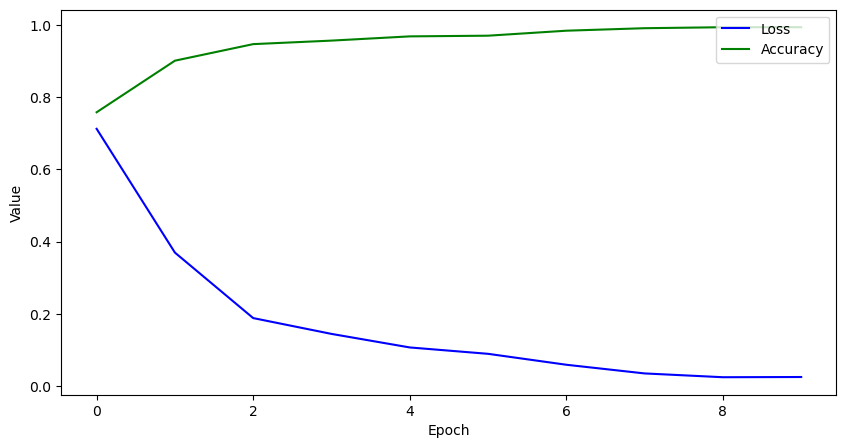

In [264]:
print(f'Accuracy: {accuracy * 100:.2f}, MSE: {mse:.4f}, MCC: {mcc:.4f}, F1 Score: {f1:.4f}%')

plt.figure(figsize=(10, 5))

# Loss grafiği
plt.plot(train_loss, label='Loss', color='blue')
plt.plot(train_acc, label='Accuracy', color='green')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')

plt.show()

In [265]:
# Doğrulama seti üzerinde modelin performansını değerlendirme
val_loss = []
val_acc = []

gru_model.eval()
total_val_loss = 0.0
correct_val = 0
total_val = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = gru_model(inputs)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        _, predicted = outputs.max(1)
        total_val += labels.size(0)
        correct_val += predicted.eq(labels).sum().item()
    # Doğrulama seti üzerindeki loss ve accuracy'yi kaydet
val_loss.append(total_val_loss / len(test_loader))
val_acc.append(correct_val / total_val)

print(val_acc)
print(val_acc)
torch.save(gru_model.state_dict(), 'GruModel.pth')

[0.9065772936740679]
[0.9065772936740679]


In [266]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, num_layers=1, bidirectional=True, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Sadece son zaman adımını kullanıyoruz
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        output = self.softmax(output)
        return output


In [267]:
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_size)
lstm_model = lstm_model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)



In [268]:
from sklearn.metrics import matthews_corrcoef

# Training the LSTM model
num_epochs = 10
train_loss = []
train_acc = []
train_mcc = []  # Added list to store MCC values

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_true_labels = []
    all_predicted_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        # Save true and predicted labels for MSE and F1 calculation
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

    # Eğitim seti üzerinde modelin performansını değerlendirme
    lstm_model.eval()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = lstm_model(inputs)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

    # Eğitim seti üzerindeki loss ve accuracy'yi kaydet
    train_loss.append(total_train_loss / len(train_loader))
    train_acc.append(correct_train / total_train)

    # Calculate MCC
    mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)
    train_mcc.append(mcc)

    # Print training statistics
    accuracy = correct_predictions / total_samples
    #print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%, MCC: {mcc:.4f}')

    mse = mean_squared_error(all_true_labels, all_predicted_labels)

    # Calculate F1 score
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

    # Print additional training statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%, MSE: {mse:.4f}, MCC: {mcc:.4f}, F1 Score: {f1:.4f}%')


Epoch 1/10, Loss: 1.3446, Accuracy: 43.79%, MSE: 3.6278, MCC: 0.2911, F1 Score: 0.4270%
Epoch 2/10, Loss: 1.2531, Accuracy: 52.38%, MSE: 3.1261, MCC: 0.4022, F1 Score: 0.5194%
Epoch 3/10, Loss: 1.1290, Accuracy: 59.48%, MSE: 2.5472, MCC: 0.4910, F1 Score: 0.5866%
Epoch 4/10, Loss: 0.8373, Accuracy: 72.66%, MSE: 1.5595, MCC: 0.6567, F1 Score: 0.7207%
Epoch 5/10, Loss: 0.6627, Accuracy: 79.11%, MSE: 1.0059, MCC: 0.7393, F1 Score: 0.7866%
Epoch 6/10, Loss: 0.5365, Accuracy: 84.77%, MSE: 0.8019, MCC: 0.8095, F1 Score: 0.8413%
Epoch 7/10, Loss: 0.4031, Accuracy: 89.36%, MSE: 0.5988, MCC: 0.8668, F1 Score: 0.8865%
Epoch 8/10, Loss: 0.3357, Accuracy: 91.09%, MSE: 0.5190, MCC: 0.8883, F1 Score: 0.9039%
Epoch 9/10, Loss: 0.3112, Accuracy: 91.93%, MSE: 0.4877, MCC: 0.8990, F1 Score: 0.9127%
Epoch 10/10, Loss: 0.2819, Accuracy: 92.35%, MSE: 0.4628, MCC: 0.9042, F1 Score: 0.9168%


Accuracy: 92.35, MSE: 0.4628, MCC: 0.9042, F1 Score: 0.9168%


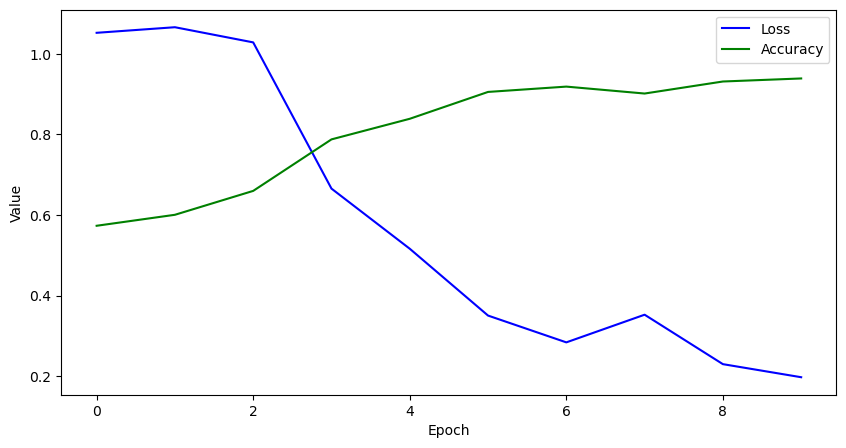

In [269]:
print(f'Accuracy: {accuracy * 100:.2f}, MSE: {mse:.4f}, MCC: {mcc:.4f}, F1 Score: {f1:.4f}%')

plt.figure(figsize=(10, 5))

# Loss grafiği
plt.plot(train_loss, label='Loss', color='blue')
plt.plot(train_acc, label='Accuracy', color='green')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')

plt.show()

In [271]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_size, dropout_prob=0.7):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a channel dimension
        conv_outputs = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled_outputs = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in conv_outputs]
        x = torch.cat(pooled_outputs, 1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x


In [272]:
filter_sizes = [2, 3, 4]  # Adjust as needed
num_filters = 100
# Instantiate the CNN model, move it to the GPU, and define the loss function and optimizer
cnn_model = CNNModel(vocab_size, embedding_dim, num_filters, filter_sizes, output_size, dropout_prob=0.3)
cnn_model = cnn_model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)


In [273]:
# Training the CNN model
# Training the CNN model
num_epochs = 10
train_loss = []
train_acc = []
train_mcc = []  # Added list to store MCC values

for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_true_labels = []
    all_predicted_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Save true and predicted labels for MCC calculation
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

    # Eğitim seti üzerinde modelin performansını değerlendirme
    cnn_model.eval()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

    # Eğitim seti üzerindeki loss ve accuracy'yi kaydet
    train_loss.append(total_train_loss / len(train_loader))
    train_acc.append(correct_train / total_train)

    # Calculate MCC
    mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)
    train_mcc.append(mcc)

    # Print training statistics
    accuracy = correct_predictions / total_samples
    #print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%, MCC: {mcc:.4f}')

    # Calculate MSE
    mse = mean_squared_error(all_true_labels, all_predicted_labels)

    # Calculate F1 score
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

    # Print additional training statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%, MCC: {mcc:.4f}, MSE: {mse:.4f}, F1 Score: {f1:.4f}%')


Epoch 1/10, Loss: 0.3755, Accuracy: 87.83%, MCC: 0.8473, MSE: 0.7729, F1 Score: 0.8737%
Epoch 2/10, Loss: 0.1723, Accuracy: 94.80%, MCC: 0.9350, MSE: 0.3581, F1 Score: 0.9472%
Epoch 3/10, Loss: 0.1322, Accuracy: 96.08%, MCC: 0.9510, MSE: 0.2626, F1 Score: 0.9604%
Epoch 4/10, Loss: 0.1304, Accuracy: 96.14%, MCC: 0.9518, MSE: 0.2587, F1 Score: 0.9611%
Epoch 5/10, Loss: 0.1086, Accuracy: 97.01%, MCC: 0.9626, MSE: 0.1873, F1 Score: 0.9699%
Epoch 6/10, Loss: 0.1050, Accuracy: 97.10%, MCC: 0.9637, MSE: 0.1881, F1 Score: 0.9710%
Epoch 7/10, Loss: 0.0809, Accuracy: 97.38%, MCC: 0.9672, MSE: 0.1647, F1 Score: 0.9737%
Epoch 8/10, Loss: 0.0772, Accuracy: 97.80%, MCC: 0.9725, MSE: 0.1420, F1 Score: 0.9779%
Epoch 9/10, Loss: 0.0716, Accuracy: 98.12%, MCC: 0.9765, MSE: 0.1278, F1 Score: 0.9812%
Epoch 10/10, Loss: 0.0754, Accuracy: 97.95%, MCC: 0.9743, MSE: 0.1278, F1 Score: 0.9794%


Accuracy: 97.95, MSE: 0.1278, MCC: 0.9743, F1 Score: 0.9794%


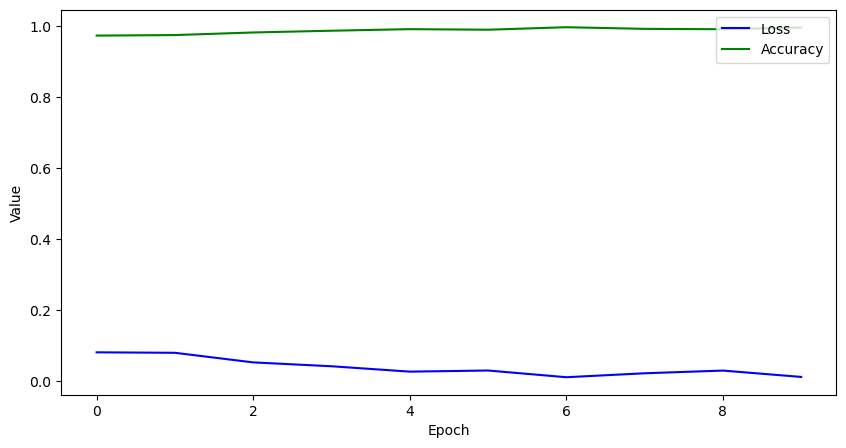

In [274]:
print(f'Accuracy: {accuracy * 100:.2f}, MSE: {mse:.4f}, MCC: {mcc:.4f}, F1 Score: {f1:.4f}%')

plt.figure(figsize=(10, 5))

# Loss grafiği
plt.plot(train_loss, label='Loss', color='blue')
plt.plot(train_acc, label='Accuracy', color='green')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')

plt.show()